In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
%pip -q install wbdata
import wbdata
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

Note: you may need to restart the kernel to use updated packages.


In [2]:
#Helper Functions

def iso3_to_wbname(iso3):
    """
    Convert ISO3 code (e.g., 'EGY') to the World Bank country name
    used inside wbdata DataFrame indexes (e.g., 'Egypt, Arab Rep.').

    If user passes a WB name already, return it unchanged.
    """
    if iso3 is None:
        return None
    if isinstance(iso3, str) and len(iso3) != 3:
        return iso3
    try:
        info = wbdata.get_country(iso3)
        if isinstance(info, list) and len(info) > 0:
            return info[0].get("name", iso3)
    except Exception:
        pass
    return iso3


def country_in_index(df, place):
    """
    Return the actual country key that exists in df.index level 0.

    Why this exists:
    - Some environments end up with country index = WB NAME (common)
    - If you pass ISO3 (EGY), you'll get "No data for country EGY"
      unless we map it to the WB name.
    """
    lvl0 = df.index.get_level_values(0)
    # if already present
    if place in set(lvl0):
        return place
    # try converting ISO3 -> WB name
    wb = iso3_to_wbname(place)
    if wb in set(lvl0):
        return wb
    return None


def year_to_date(year):
    return pd.Timestamp(f"{int(year)}-01-01")


def available_years(df, country_key):
    """
    Return available integer years for a country_key in the population dataframe.
    """
    if country_key not in df.index.get_level_values(0):
        return []
    idx = df.loc[country_key].index
    if np.issubdtype(idx.dtype, np.datetime64):
        return sorted(pd.to_datetime(idx).year.unique())
    return sorted(pd.Series(idx).unique())


def nearest_year(df, country_key, year):
    """
    Find nearest available year for that country in df.
    """
    yrs = available_years(df, country_key)
    if not yrs:
        return None
    return min(yrs, key=lambda y: abs(int(y) - int(year)))


def acronymfinder(query, max_results=20):
    q = str(query).lower()
    matches = []
    for c in wbdata.get_country(display=False):
        name = c.get("name", "")
        iso3 = c.get("id", "")
        if q in name.lower() or q in iso3.lower():
            matches.append((iso3, name))
    for iso3, name in matches[:max_results]:
        print(f"{name}: {iso3}")
    if len(matches) > max_results:
        print(f"... ({len(matches)-max_results} more)")

In [3]:
# 2. [A] Population DataFrames 

def get_population_by_age_sex(countries):
    """
    [A] DELIVERABLE 2: Population DataFrames

    Fetches population by age and sex from the World Bank (WDI).

    IMPORTANT:
    - wbdata indexes by World Bank COUNTRY NAME (not ISO3) in most setups.
    - We'll handle that later with country_in_index().
    """
    indicators = {
        "SP.POP.0004.MA": "Male 0-4",   "SP.POP.0004.FE": "Female 0-4",
        "SP.POP.0509.MA": "Male 5-9",   "SP.POP.0509.FE": "Female 5-9",
        "SP.POP.1014.MA": "Male 10-14", "SP.POP.1014.FE": "Female 10-14",
        "SP.POP.1519.MA": "Male 15-19", "SP.POP.1519.FE": "Female 15-19",
        "SP.POP.2024.MA": "Male 20-24", "SP.POP.2024.FE": "Female 20-24",
        "SP.POP.2529.MA": "Male 25-29", "SP.POP.2529.FE": "Female 25-29",
        "SP.POP.3034.MA": "Male 30-34", "SP.POP.3034.FE": "Female 30-34",
        "SP.POP.3539.MA": "Male 35-39", "SP.POP.3539.FE": "Female 35-39",
        "SP.POP.4044.MA": "Male 40-44", "SP.POP.4044.FE": "Female 40-44",
        "SP.POP.4549.MA": "Male 45-49", "SP.POP.4549.FE": "Female 45-49",
        "SP.POP.5054.MA": "Male 50-54", "SP.POP.5054.FE": "Female 50-54",
        "SP.POP.5559.MA": "Male 55-59", "SP.POP.5559.FE": "Female 55-59",
        "SP.POP.6064.MA": "Male 60-64", "SP.POP.6064.FE": "Female 60-64",
        "SP.POP.6569.MA": "Male 65-69", "SP.POP.6569.FE": "Female 65-69",
        "SP.POP.7074.MA": "Male 70-74", "SP.POP.7074.FE": "Female 70-74",
        "SP.POP.7579.MA": "Male 75-79", "SP.POP.7579.FE": "Female 75-79",
        "SP.POP.80UP.MA": "Male 80+",   "SP.POP.80UP.FE": "Female 80+",
    }

    country_keys = list(countries.keys())
    df = wbdata.get_dataframe(indicators, country=country_keys, parse_dates=True).squeeze()

    #Drop rows where ALL age-sex bins are NaN
    df = df.dropna(how="all")

    return df

In [4]:
# 1. [A] Population Statistics

def population(year, sex, age_range, place, graph=False, pop_df=None):
    """
    [A] DELIVERABLE 1: Population Statistics

    Returns population estimate (approx by overlapping 5-yr bins).
    If graph=True, shows trend across available years.
    """
    if pop_df is None:
        pop_df = POP_DF

    # FIX: find actual country key in index
    country_key = country_in_index(pop_df, place)
    if country_key is None:
        return "No data"

    y = nearest_year(pop_df, country_key, year)
    if y is None:
        return "No data"

    date = year_to_date(y)
    low, high = int(age_range[0]), int(age_range[1])

    bins = [
        (0,4,"0-4"), (5,9,"5-9"), (10,14,"10-14"), (15,19,"15-19"),
        (20,24,"20-24"), (25,29,"25-29"), (30,34,"30-34"), (35,39,"35-39"),
        (40,44,"40-44"), (45,49,"45-49"), (50,54,"50-54"), (55,59,"55-59"),
        (60,64,"60-64"), (65,69,"65-69"), (70,74,"70-74"), (75,79,"75-79"),
        (80,200,"80+")
    ]
    overlapping = [lab for a,b,lab in bins if not (b < low or a > high)]

    def cols(prefix):
        return [f"{prefix} {lab}" for lab in overlapping]

    try:
        row = pop_df.loc[(country_key, date)]
    except Exception:
        return "No data"

    if sex == "MA":
        total = float(np.nansum(row[cols("Male")].values))
    elif sex == "FE":
        total = float(np.nansum(row[cols("Female")].values))
    elif sex == "ALL":
        total = float(np.nansum(row[cols("Male")].values) + np.nansum(row[cols("Female")].values))
    else:
        raise ValueError("sex must be 'MA', 'FE', or 'ALL'")

    if not np.isfinite(total) or total <= 0:
        return "No data"

    if graph:
        yrs = available_years(pop_df, country_key)
        vals = []
        for yy in yrs:
            d = year_to_date(yy)
            try:
                r = pop_df.loc[(country_key, d)]
                if sex == "MA":
                    vals.append(np.nansum(r[cols("Male")].values))
                elif sex == "FE":
                    vals.append(np.nansum(r[cols("Female")].values))
                else:
                    vals.append(np.nansum(r[cols("Male")].values) + np.nansum(r[cols("Female")].values))
            except Exception:
                vals.append(np.nan)

        # drop NaNs before plotting (so something always shows)
        s = pd.Series(vals, index=yrs).dropna()
        if len(s) > 0:
            plt.figure(figsize=(9,4))
            plt.plot(s.index, s.values)
            plt.title(f"{country_key}: {sex} population ages {low}-{high}")
            plt.xlabel("Year")
            plt.ylabel("Population")
            plt.grid(True, alpha=0.25)
            plt.show()

    return total

In [5]:
# Water + Ag panel

def get_water_ag_panel(countries):
    """
    Pulls water/ag indicators + builds derived ag water per capita.

    Adds dropna to prevent broken joins/plots.
    """
    indicators = {
        "ER.H2O.FWST.ZS": "water_stress_pct",
        "ER.H2O.FWTL.K3": "total_withdrawal_bcm",
        "ER.H2O.FWAG.ZS": "ag_withdraw_share_pct",
        "AG.YLD.CREL.KG": "cereal_yield_kg_ha",
        "SL.AGR.EMPL.ZS": "ag_employment_share_pct",
        "NY.GDP.PCAP.KD": "gdp_pc_const_usd",
        "SP.POP.TOTL":    "population_total",
    }
    df = wbdata.get_dataframe(indicators, country=list(countries.keys()), parse_dates=True).squeeze()

    # drop rows where EVERYTHING is NaN
    df = df.dropna(how="all")

    df["ag_withdrawal_bcm"] = df["total_withdrawal_bcm"] * (df["ag_withdraw_share_pct"]/100.0)
    df["ag_water_pc_m3"] = (df["ag_withdrawal_bcm"] * 1e9) / df["population_total"]

    return df

In [6]:
# 3. [B] Population Pyramids (STATIC) + WATER/AG ANNOTATIONS

def plot_population_pyramid(df, country, date, water_df=None):
    """
    [B] DELIVERABLE 3: Static Population Pyramids

    country can be ISO3 or WB name.
    """
    country_key = country_in_index(df, country)
    if country_key is None:
        print(f"No population pyramid data for {country}")
        return

    date = pd.Timestamp(date)

    age_bins = ["0-4","5-9","10-14","15-19","20-24","25-29","30-34","35-39",
                "40-44","45-49","50-54","55-59","60-64","65-69","70-74","75-79","80+"]

    try:
        male = df.loc[(country_key, date), [f"Male {b}" for b in age_bins]].values / 1e6
        fem  = df.loc[(country_key, date), [f"Female {b}" for b in age_bins]].values / 1e6
    except Exception:
        print(f"No population pyramid data for {country_key} at {date.date()}")
        return

    male = np.nan_to_num(male, nan=0.0)
    fem  = np.nan_to_num(fem,  nan=0.0)

    fig, ax = plt.subplots(figsize=(10,6))
    ax.barh(age_bins, -male, label="Male")
    ax.barh(age_bins,  fem, label="Female")

    ax.set_xlabel("Population (millions)")
    ax.set_ylabel("Age Group")
    ax.set_title(f"Population Pyramid for {country_key} on {date.date()}")
    ax.legend()
    ax.grid(True, axis="x", alpha=0.2)

    # Water/ag annotation box 
    if water_df is not None:
        try:
            w_country_key = country_in_index(water_df, country)
            if w_country_key is not None:
                w = water_df.loc[(w_country_key, date)]

                water_stress = w.get("water_stress_pct", np.nan)
                ag_pc = w.get("ag_water_pc_m3", np.nan)
                yield_kg = w.get("cereal_yield_kg_ha", np.nan)
                ag_emp = w.get("ag_employment_share_pct", np.nan)

                water_stress_s = "NA" if pd.isna(water_stress) else f"{water_stress:.1f}%"
                ag_pc_s = "NA" if pd.isna(ag_pc) else f"{ag_pc:.0f} m³/person"
                yield_s = "NA" if pd.isna(yield_kg) else f"{yield_kg:.0f} kg/ha"
                ag_emp_s = "NA" if pd.isna(ag_emp) else f"{ag_emp:.1f}%"

                note = (
                    f"Water stress: {water_stress_s}\n"
                    f"Ag water per capita: {ag_pc_s}\n"
                    f"Cereal yield: {yield_s}\n"
                    f"% employed in ag: {ag_emp_s}"
                )

                ax.text(
                    0.98, 0.02, note,
                    transform=ax.transAxes,
                    ha="right", va="bottom",
                    bbox=dict(boxstyle="round", alpha=0.15)
                )
        except Exception:
            pass

    plt.show()

In [7]:
# 4. [C] Animated Population Pyramids

import numpy as np
import pandas as pd
import plotly.express as px

def animated_population_pyramid_wide(df, country, animate_by='year'):
    """
    [C] DELIVERABLE 4: Animated Population Pyramids (Plotly)

    What it does
    ------------
    Takes the wide World Bank age-sex population dataframe (MultiIndex: country,date)
    and produces an animated population pyramid over time.
    - Accepts either WB country name ("Egypt, Arab Rep.") OR ISO3 ("EGY") if country_in_index supports it
    - Drops NaN/inf values before plotting so Plotly doesn't crash
    - Raises clear errors if the selected country has no usable data
    """

    # ---- 1) Resolve country name
    country_key = country_in_index(df, country)
    if country_key is None:
        raise ValueError(f"No data for country {country}. Try a different country/year or confirm name.")

    # ---- 2) Wide -> long format
    df_reset = df.reset_index()  # columns: country, date, "Male 0-4", ...
    df_long = df_reset.melt(
        id_vars=['country', 'date'],
        var_name='age_sex',
        value_name='population'
    )

    # Split "Male 0-4" into sex + age_group
    df_long[['sex', 'age_group']] = df_long['age_sex'].str.split(' ', n=1, expand=True)

    # ---- 3) Animation frame column
    if animate_by == 'year':
        df_long['year'] = pd.to_datetime(df_long['date']).dt.year
        frame_col = 'year'
    elif animate_by == 'date':
        frame_col = 'date'
    else:
        raise ValueError("animate_by must be either 'year' or 'date'.")

    # ---- 4) Filter to country + drop NaN / inf
    df_country = df_long[df_long['country'] == country_key].copy()

    # Convert to numeric just in case (sometimes WB pulls as object)
    df_country['population'] = pd.to_numeric(df_country['population'], errors='coerce')

    # Drop missing + non-finite
    df_country = df_country.dropna(subset=['population'])
    df_country = df_country[np.isfinite(df_country['population'])]

    if df_country.empty:
        raise ValueError(f"No non-NaN population values for {country_key}. Try a different year range or country.")

    # ---- 5) Make males negative so they appear on left
    df_country.loc[df_country['sex'].str.lower() == 'male', 'population'] *= -1

    # ---- 6) Age ordering
    age_categories = [
        "0-4","5-9","10-14","15-19","20-24","25-29",
        "30-34","35-39","40-44","45-49","50-54","55-59",
        "60-64","65-69","70-74","75-79","80+"
    ]
    df_country['age_group'] = pd.Categorical(
        df_country['age_group'],
        categories=age_categories,
        ordered=True
    )

    # ---- 7) Plotly animation
    fig = px.bar(
        df_country,
        x='population',
        y='age_group',
        color='sex',
        animation_frame=frame_col,
        orientation='h',
        range_x=[df_country['population'].min() * 1.1, df_country['population'].max() * 1.1],
        title=f"Animated Population Pyramid for {country_key}"
    )

    fig.update_yaxes(categoryorder='array', categoryarray=age_categories)
    fig.update_layout(
    width=1100,          
    height=600,         
    margin=dict(l=80, r=80, t=80, b=60),
    xaxis_title="Population (negative = Male, positive = Female)",
    yaxis_title="Age Group",
)

    return fig

In [8]:
# 5. [C] Population Maps

def popmap_total_population(countries, year=2020):
    """
    [C] DELIVERABLE 5: Population Maps 
    """
    indicators = {"SP.POP.TOTL": "Total Population"}
    df = wbdata.get_dataframe(indicators, country=list(countries.keys()), parse_dates=True).squeeze()
    df = df.dropna(how="all")

    target_date = pd.Timestamp(f"{int(year)}-01-01")
    try:
        row = df.xs(target_date, level="date")
    except Exception:
        print(f"No data for year {year}")
        return

    map_df = row.reset_index()
    map_df.columns = ["country", "population"]
    map_df = map_df.dropna(subset=["population"])

    fig = px.choropleth(
        map_df,
        locations="country",
        locationmode="country names",
        color="population",
        hover_name="country",
        title=f"Population Map — {year}"
    )
    fig.show()

In [9]:
# Table of Contents

display(Markdown("""
# Deliverables and Functions
This notebook contains the functions we have used and the deliverables we have completed.

## Table of Contents
1. [A] [Population Statistics](#1-a-population-statistics)  
2. [A] [Population DataFrames](#2-a-population-dataframes)  
3. [B] [Population Pyramids](#3-b-population-pyramids)  
4. [C] [Animated Population Pyramids](#4-c-animated-population-pyramids)  
5. [C] [Population Maps](#5-c-population-maps)  
6. [C] [Other Visualization Tools](#6-c-other-visualization-tools)
"""))

COUNTRIES = {
    # water-scarce
    "SAU": "Saudi Arabia (water-scarce)",
    "IND": "India (water-scarce)",
    "BHR": "Bahrain (water-scarce)",

    # water-abundant
    "BRA": "Brazil (water-abundant)",
    "CAN": "Canada (water-abundant)",
    "RUS": "Russia (water-abundant)",
}

POP_DF = get_population_by_age_sex(COUNTRIES)
WATER_DF = get_water_ag_panel(COUNTRIES)


# Deliverables and Functions
This notebook contains the functions we have used and the deliverables we have completed.

## Table of Contents
1. [A] [Population Statistics](#1-a-population-statistics)  
2. [A] [Population DataFrames](#2-a-population-dataframes)  
3. [B] [Population Pyramids](#3-b-population-pyramids)  
4. [C] [Animated Population Pyramids](#4-c-animated-population-pyramids)  
5. [C] [Population Maps](#5-c-population-maps)  
6. [C] [Other Visualization Tools](#6-c-other-visualization-tools)


#### 1. [A] Population Statistics

Egypt: No data


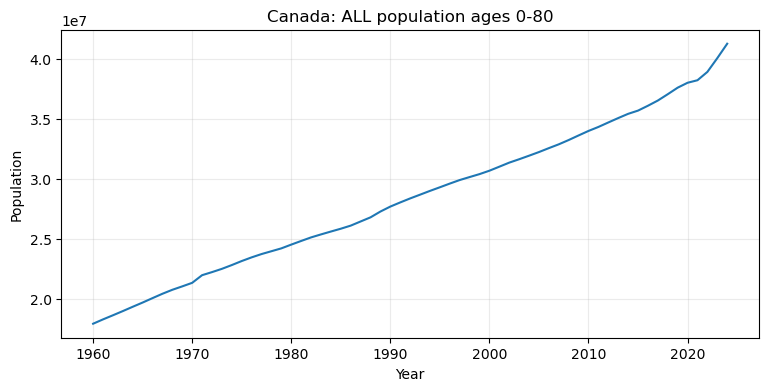

Canada: 30685733.0


In [10]:
display(Markdown("#### 1. [A] Population Statistics"))
print("Egypt:", population(2000, "ALL", [0, 80], "Egypt, Arab Rep.", graph=True, pop_df=POP_DF))
print("Canada:", population(2000, "ALL", [0, 80], "Canada", graph=True, pop_df=POP_DF))

In [11]:
display(Markdown("#### 2. [A] Population DataFrames"))
display(POP_DF.head())
display(WATER_DF.head())

#### 2. [A] Population DataFrames

Male 0-4  Female 0-4  Male 5-9  Female 5-9  Male 10-14  \
country date                                                                 
Bahrain 2024-01-01   47973.0     46369.0   52706.0     50904.0     50842.0   
        2023-01-01   48429.0     46719.0   53819.0     51876.0     50455.0   
        2022-01-01   48529.0     46850.0   52427.0     50303.0     47308.0   
        2021-01-01   49937.0     48186.0   51585.0     49495.0     46725.0   
        2020-01-01   51044.0     49279.0   51709.0     49651.0     46828.0   

                    Female 10-14  Male 15-19  Female 15-19  Male 20-24  \
country date                                                             
Bahrain 2024-01-01       48554.0     44851.0       42214.0     65647.0   
        2023-01-01       48216.0     44331.0       41358.0     67312.0   
        2022-01-01       45479.0     48039.0       40004.0     71553.0   
        2021-01-01       44281.0     52854.0       40936.0     76236.0   
        2020-01-01       44379.0     47067.0       39649.0     68832.0   

                    Female 20-24  ...  Male 60-64  Female 60-64  Male 65-69  \
country date                      ...                                         
Bahrain 2024-01-01       39947.0  ...     24913.0       19780.0     15655.0   
        2023-01-01       39693.0  ...     23839.0       19089.0     14696.0   
        2022-01-01       43312.0  ...     22613.0       18190.0     13695.0   
        2021-01-01       48045.0  ...     23048.0       17650.0     13542.0   
        2020-01-01       44217.0  ...     22401.0       16352.0     12631.0   

                    Female 65-69  Male 70-74  Female 70-74  Male 75-79  \
country date                                                             
Bahrain 2024-01-01       13184.0      7690.0        6907.0      4230.0   
        2023-01-01       12318.0      6824.0        6232.0      4213.0   
        2022-01-01       11144.0      6309.0        5833.0      4130.0   
        2021-01-01       10437.0      6397.0        5862.0      4120.0   
        2020-01-01        9453.0      5896.0        5469.0      3761.0   

                    Female 75-79  Male 80+  Female 80+  
country date                                            
Bahrain 2024-01-01        4057.0    4670.0      4824.0  
        2023-01-01        4017.0    4436.0      4636.0  
        2022-01-01        3908.0    4071.0      4259.0  
        2021-01-01        3902.0    3838.0      4017.0  
        2020-01-01        3646.0    3562.0      3856.0  

[5 rows x 34 columns]

water_stress_pct  total_withdrawal_bcm  \
country date                                                 
Bahrain 2024-01-01               NaN                   NaN   
        2023-01-01               NaN                   NaN   
        2022-01-01        133.706897                0.1551   
        2021-01-01        133.706897                0.1551   
        2020-01-01        133.706897                0.1551   

                    ag_withdraw_share_pct  cereal_yield_kg_ha  \
country date                                                    
Bahrain 2024-01-01                    NaN                 NaN   
        2023-01-01                    NaN                 NaN   
        2022-01-01              33.310313                 NaN   
        2021-01-01              33.310313                 NaN   
        2020-01-01              33.310313                 NaN   

                    ag_employment_share_pct  gdp_pc_const_usd  \
country date                                                    
Bahrain 2024-01-01                 0.855980      25812.450458   
        2023-01-01                 0.881003      25342.622664   
        2022-01-01                 0.909630      25234.402562   
        2021-01-01                 0.936349      24086.784780   
        2020-01-01                 0.952586      23586.930958   

                    population_total  ag_withdrawal_bcm  ag_water_pc_m3  
country date                                                             
Bahrain 2024-01-01         1588670.0                NaN             NaN  
        2023-01-01         1577059.0                NaN             NaN  
        2022-01-01         1524693.0           0.051664       33.885048  
        2021-01-01         1504365.0           0.051664       34.342926  
        2020-01-01         1472204.0           0.051664       35.093163

#### 5. [C] Population Maps

/tmp/ipykernel_7108/3590684151.py:22: DeprecationWarning: The library used by the *country names* `locationmode` option is changing in an upcoming version. Country names in existing plots may not work in the new version. To ensure consistent behavior, consider setting `locationmode` to *ISO-3*.
  fig = px.choropleth(


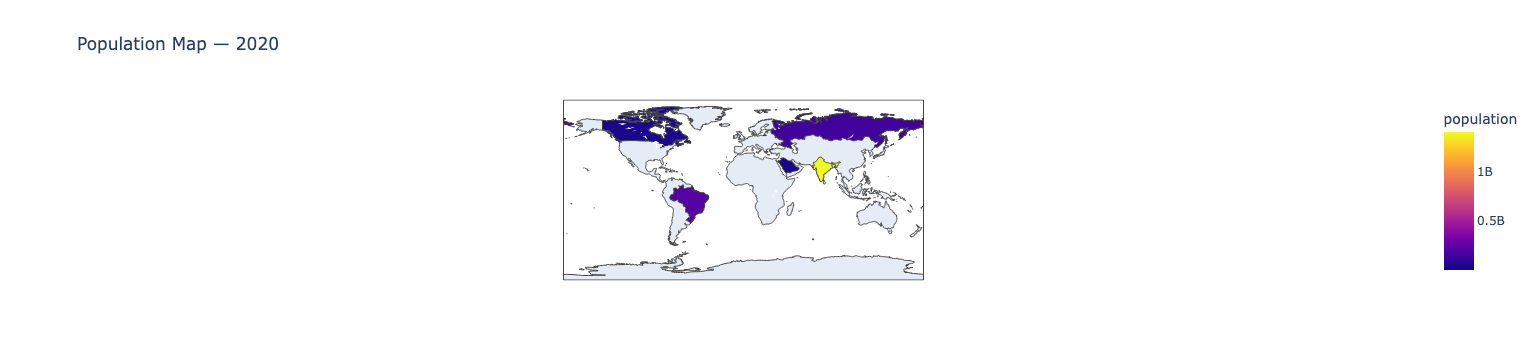

/tmp/ipykernel_7108/3590684151.py:22: DeprecationWarning:

The library used by the *country names* `locationmode` option is changing in an upcoming version. Country names in existing plots may not work in the new version. To ensure consistent behavior, consider setting `locationmode` to *ISO-3*.



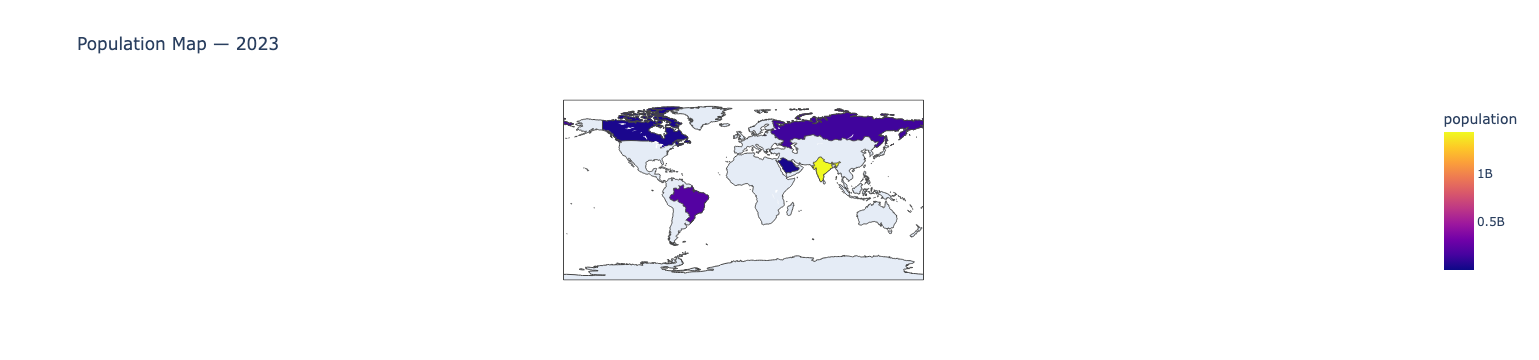

/tmp/ipykernel_7108/3590684151.py:22: DeprecationWarning:

The library used by the *country names* `locationmode` option is changing in an upcoming version. Country names in existing plots may not work in the new version. To ensure consistent behavior, consider setting `locationmode` to *ISO-3*.



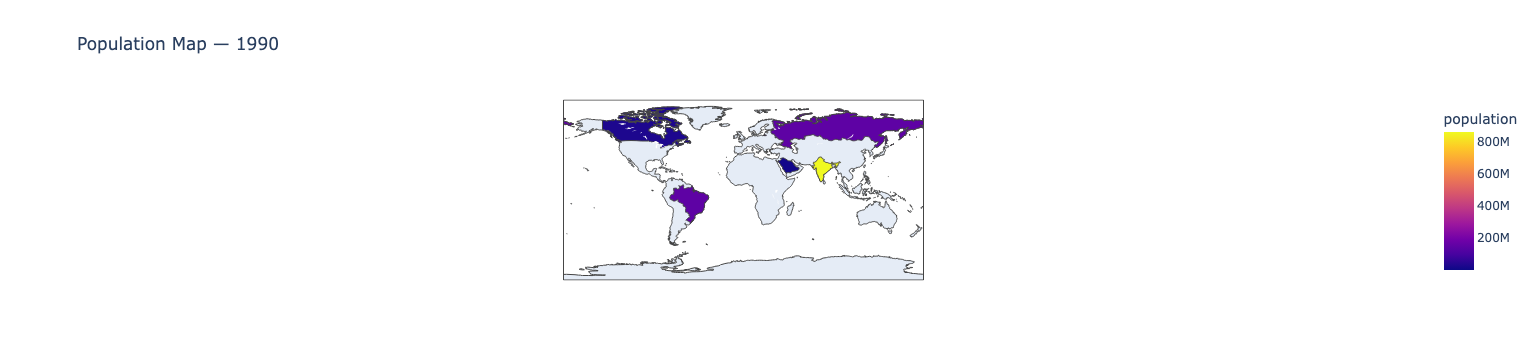

In [12]:
display(Markdown("#### 5. [C] Population Maps"))
popmap_total_population(COUNTRIES, year=2020)
popmap_total_population(COUNTRIES, year=2023)

# optional comparison year
popmap_total_population(COUNTRIES, year=1990)

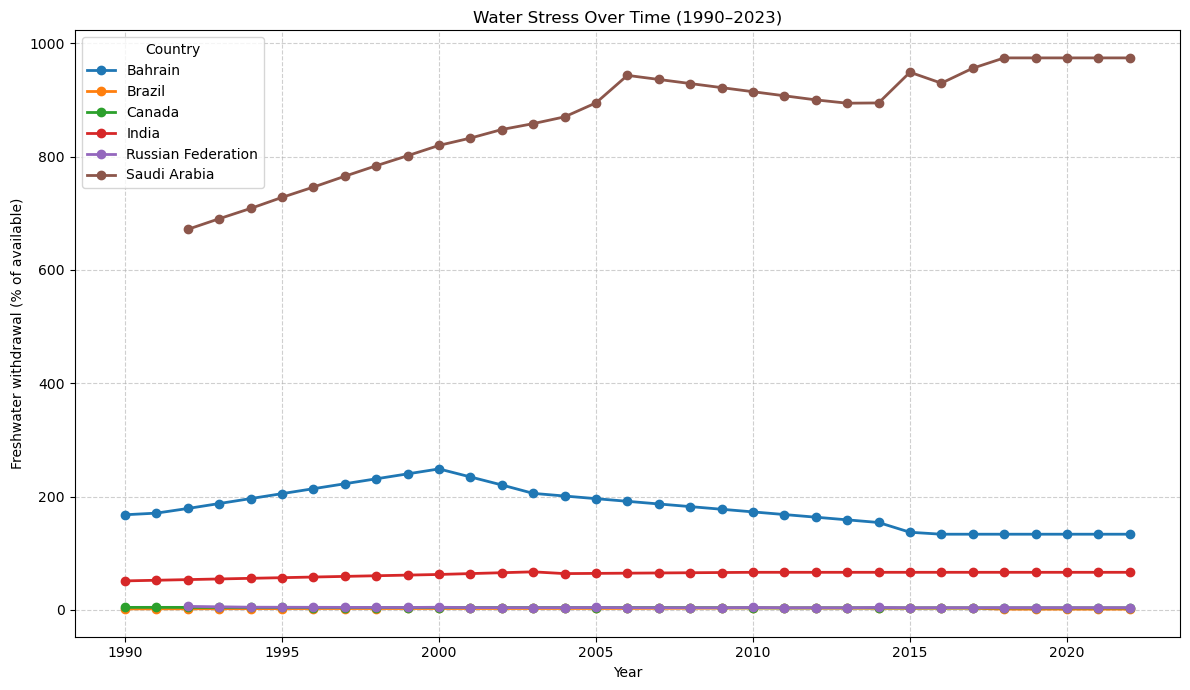

Base year with full data: 1992


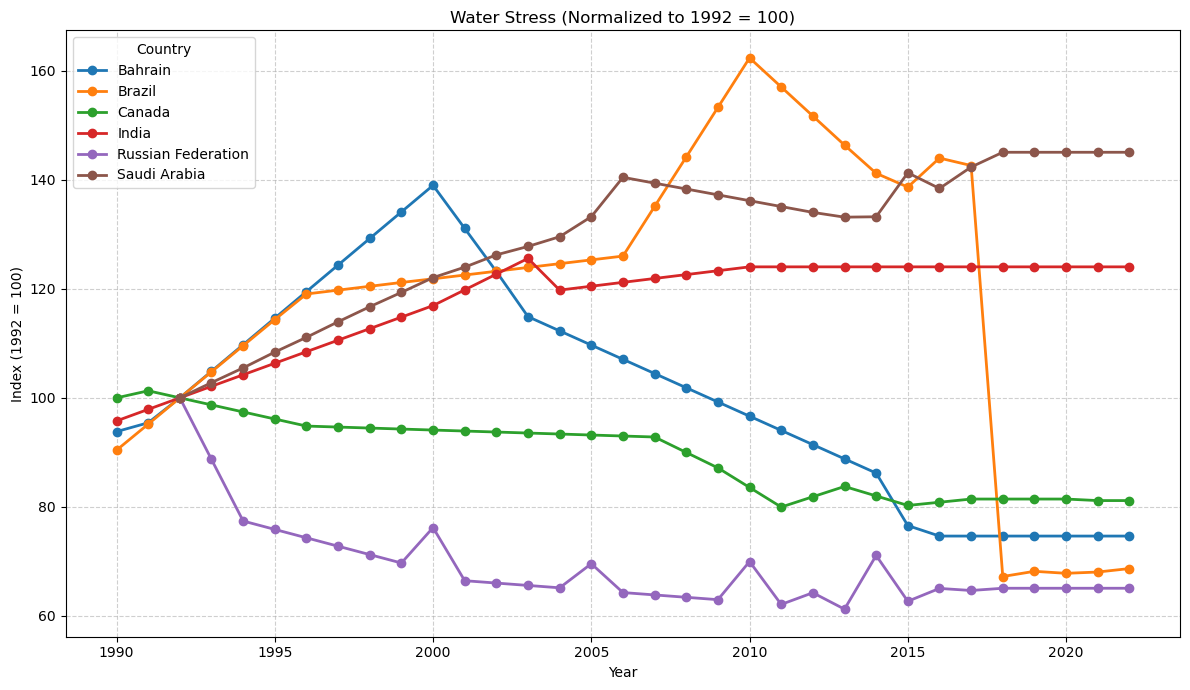

In [13]:
# 6. [C] Other Visualization Tools 

# water stress graph raw
import wbdata
import pandas as pd
import matplotlib.pyplot as plt

# Indicator
indicator = {"ER.H2O.FWST.ZS": "Water Stress (%)"}

# Countries
countries = ["BH", "SA", "IN", "BR", "RU", "CA"]

# Date range
date_range = (pd.Timestamp("1990-01-01"), pd.Timestamp("2023-01-01"))

# Fetch data
df = wbdata.get_dataframe(indicator, country=countries, date=date_range)

# Clean
df = df.reset_index()
df["date"] = pd.to_datetime(df["date"])
df["year"] = df["date"].dt.year

# Pivot to wide format
wide = df.pivot_table(index="year",
                      columns="country",
                      values="Water Stress (%)").sort_index()

# Plot
plt.figure(figsize=(12, 7))

for country in wide.columns:
    plt.plot(wide.index, wide[country], marker='o', linewidth=2, label=country)

plt.title("Water Stress Over Time (1990–2023)")
plt.xlabel("Year")
plt.ylabel("Freshwater withdrawal (% of available)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(title="Country")
plt.tight_layout()
plt.show()

# water stress graph normalized

import wbdata
import pandas as pd
import matplotlib.pyplot as plt

# Indicator
indicator = {"ER.H2O.FWST.ZS": "Water Stress (%)"}

# Countries
countries = ["BH", "SA", "IN", "BR", "RU", "CA"]

# Date range
date_range = (pd.Timestamp("1990-01-01"), pd.Timestamp("2023-01-01"))

# Fetch data
df = wbdata.get_dataframe(indicator, country=countries, date=date_range)

# Clean
df = df.reset_index()
df["date"] = pd.to_datetime(df["date"])
df["year"] = df["date"].dt.year

# Pivot to wide format
wide = (
    df.pivot_table(index="year", columns="country", values="Water Stress (%)")
      .sort_index()
)

# ---- FIND FIRST YEAR WITH FULL DATA ----
full_years = wide.dropna().index
if len(full_years) == 0:
    raise ValueError("No year has complete data for all countries in this range.")

base_year = int(full_years[0])
print(f"Base year with full data: {base_year}")

# ---- NORMALIZE TO BASE YEAR = 100 ----
wide_normalized = wide.div(wide.loc[base_year]) * 100

# Plot normalized data
plt.figure(figsize=(12, 7))

for country in wide_normalized.columns:
    plt.plot(
        wide_normalized.index,
        wide_normalized[country],
        marker="o",
        linewidth=2,
        label=country
    )

plt.title(f"Water Stress (Normalized to {base_year} = 100)")
plt.xlabel("Year")
plt.ylabel(f"Index ({base_year} = 100)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(title="Country")
plt.tight_layout()
plt.show()


In [14]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import plotly.express as px

COUNTRIES = {
    # water-scarce
    "SAU": "Saudi Arabia (water-scarce)",
    "IND": "India (water-scarce)",
    "BHR": "Bahrain (water-scarce)",
    # water-abundant
    "BRA": "Brazil (water-abundant)",
    "CAN": "Canada (water-abundant)",
    "RUS": "Russia (water-abundant)",
}

SCARCE = {"SAU", "IND", "BHR"}
ABUNDANT = {"BRA", "CAN", "RUS"}

AGE_CODES = [
    ("0004", "0-4"),
    ("0509", "5-9"),
    ("1014", "10-14"),
    ("1519", "15-19"),
    ("2024", "20-24"),
    ("2529", "25-29"),
    ("3034", "30-34"),
    ("3539", "35-39"),
    ("4044", "40-44"),
    ("4549", "45-49"),
    ("5054", "50-54"),
    ("5559", "55-59"),
    ("6064", "60-64"),
    ("6569", "65-69"),
    ("7074", "70-74"),
    ("7579", "75-79"),
    ("80UP", "80+"),
]


In [15]:
_WB_CACHE = {}  # (country, indicator, start, end) -> {year:int -> value:float}

def wb_series(country: str, indicator: str, start=1990, end=2023) -> dict:
    """
    Return dict {year:int -> value:float} for one country+indicator over [start,end].
    IMPORTANT: build URL manually so 'date=1990:2023' is NOT encoded to '1990%3A2023'
    (WB API sometimes 400s on the encoded version).
    """
    key = (country, indicator, start, end)
    if key in _WB_CACHE:
        return _WB_CACHE[key]

    base = f"https://api.worldbank.org/v2/country/{country}/indicator/{indicator}"
    url = f"{base}?date={start}:{end}&format=json&per_page=20000"  # <-- keep colon literal

    r = requests.get(url, timeout=30, headers={"User-Agent": "Mozilla/5.0"})
    # don't immediately raise — show debug if it fails
    if r.status_code != 200:
        raise RuntimeError(f"WB API error {r.status_code} for {country} {indicator}: {r.text[:200]}")

    data = r.json()

    out = {}
    if isinstance(data, list) and len(data) > 1 and data[1]:
        for item in data[1]:
            yr = item.get("date")
            val = item.get("value")
            if yr is None:
                continue
            try:
                y = int(yr)
            except Exception:
                continue
            out[y] = float(val) if val is not None else np.nan

    _WB_CACHE[key] = out
    return out

def wb_value(country: str, indicator: str, year: int, start=1990, end=2023) -> float:
    s = wb_series(country, indicator, start=start, end=end)
    return float(s.get(int(year), np.nan))


In [16]:
def plot_pyramid_api(country: str, year: int, title_extra=""):
    ages = [label for _, label in AGE_CODES]
    male = []
    female = []

    for code, _label in AGE_CODES:
        m_ind = f"SP.POP.{code}.MA"
        f_ind = f"SP.POP.{code}.FE"
        m_val = wb_value(country, m_ind, year)
        f_val = wb_value(country, f_ind, year)
        male.append(-m_val)   # left
        female.append(f_val)  # right

    if all(np.isnan(male)) and all(np.isnan(female)):
        print(f"No pyramid data for {country} {year}")
        return

    fig, ax = plt.subplots(figsize=(9, 7))
    ax.barh(ages, male, label="Male")
    ax.barh(ages, female, label="Female")
    ax.axvline(0, color="black")

    # symmetric x-limits
    mm = np.nanmax(np.abs(male)) if np.any(np.isfinite(male)) else 0
    ff = np.nanmax(np.abs(female)) if np.any(np.isfinite(female)) else 0
    max_val = max(mm, ff)
    ax.set_xlim(-max_val * 1.05, max_val * 1.05)

    ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: f"{abs(int(x)):,}"))
    ax.set_title(f"Population Pyramid — {country} ({year}) {title_extra}".strip())
    ax.set_xlabel("Population")
    ax.set_ylabel("Age Group")
    ax.grid(axis="x", linestyle="--", alpha=0.6)
    ax.legend()
    plt.tight_layout()
    plt.show()


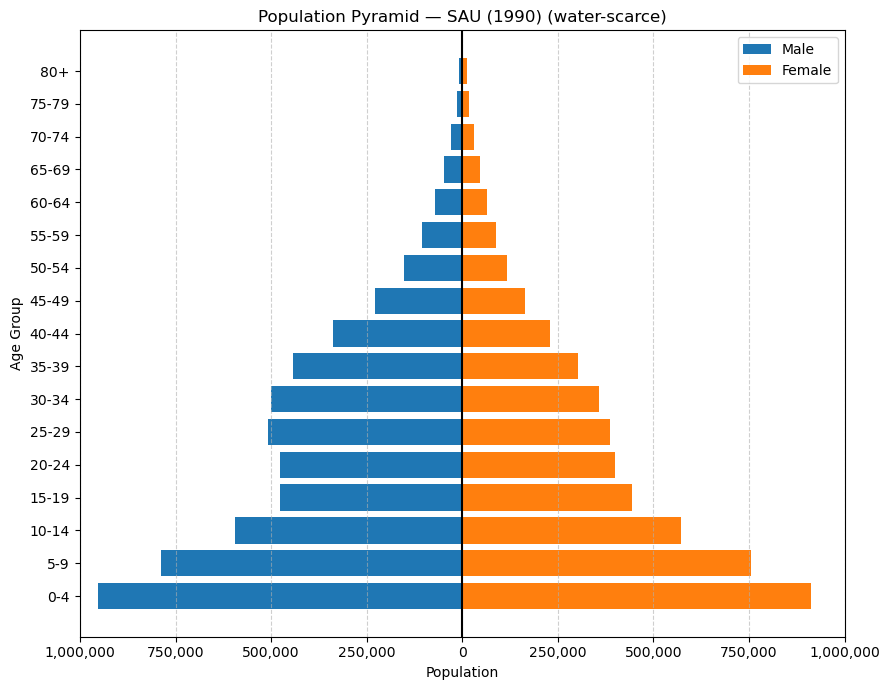

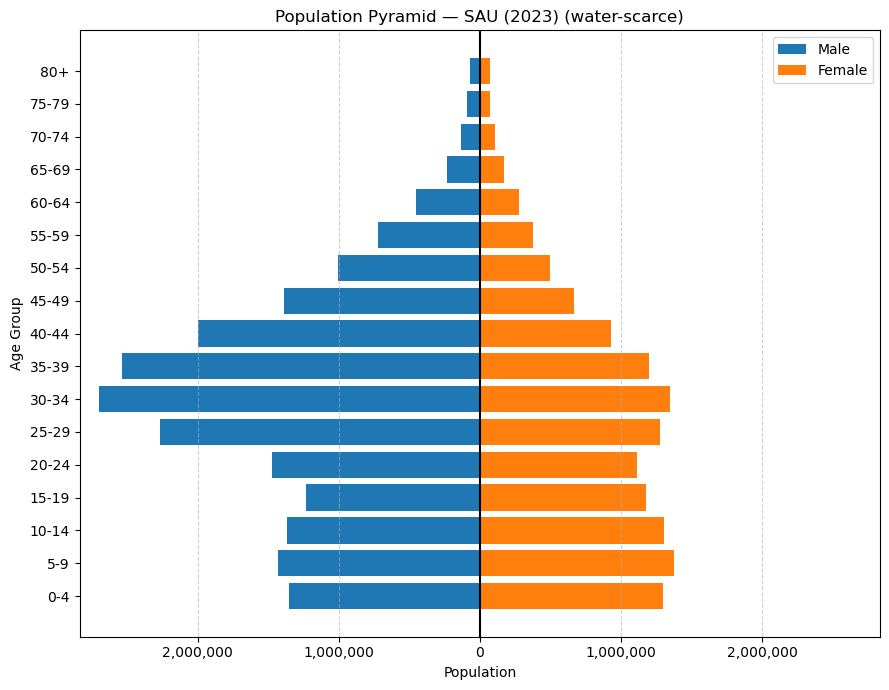

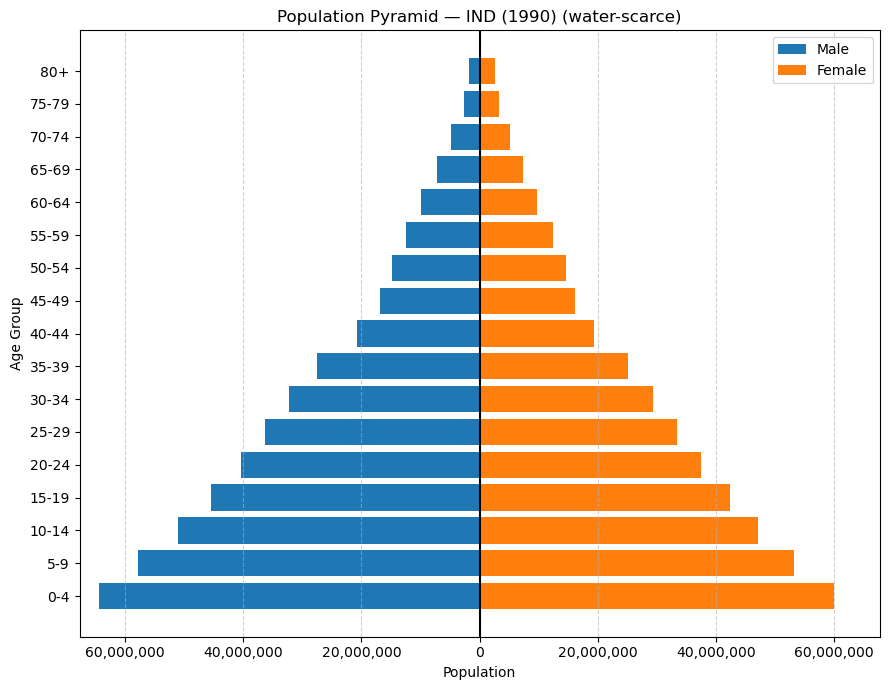

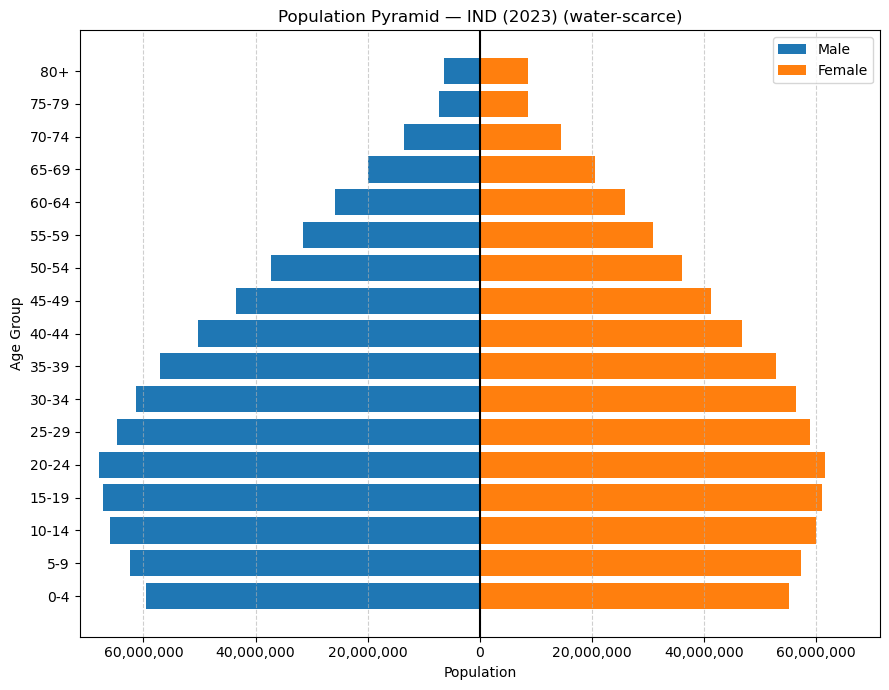

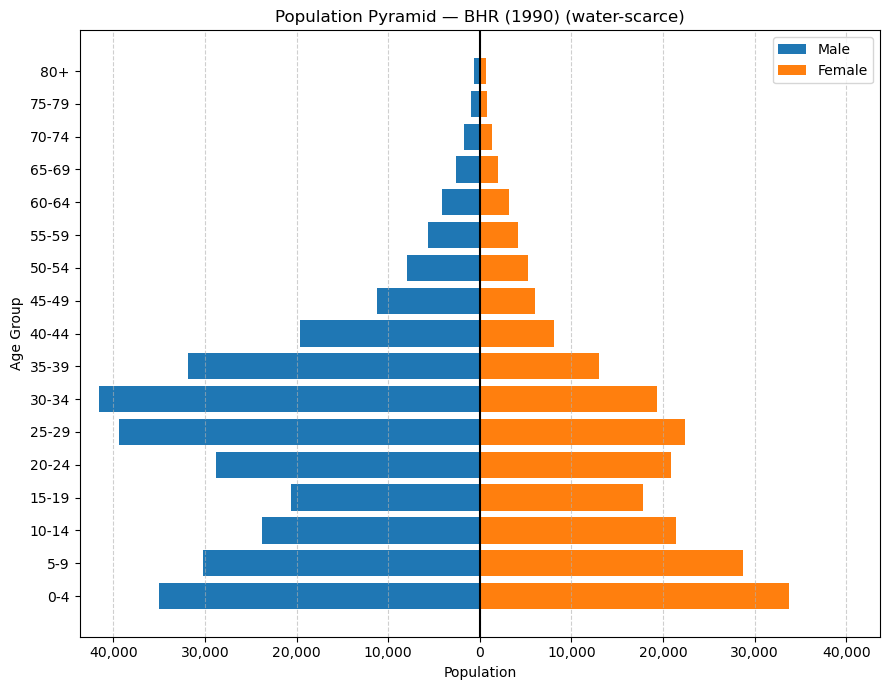

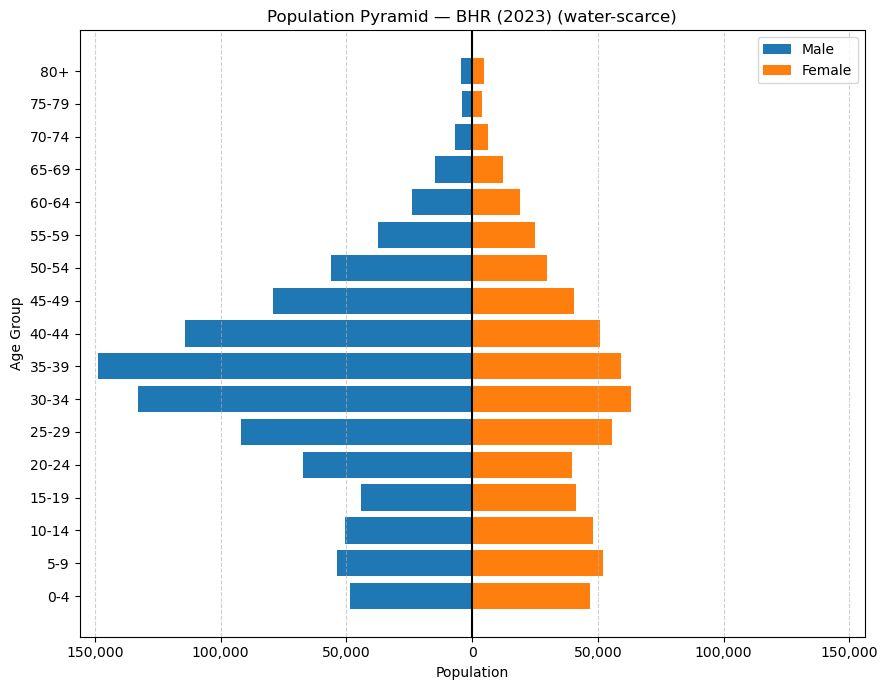

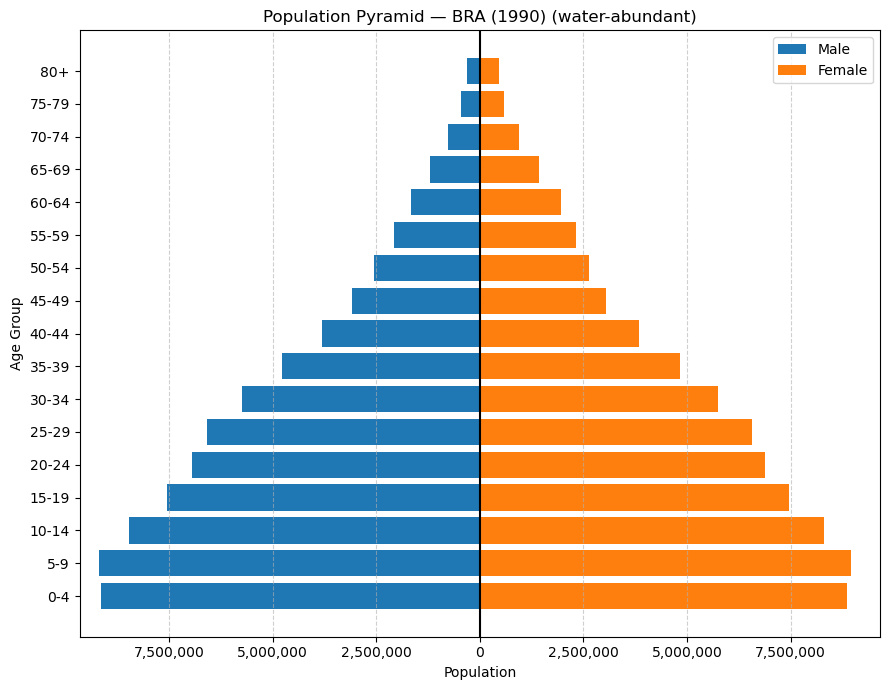

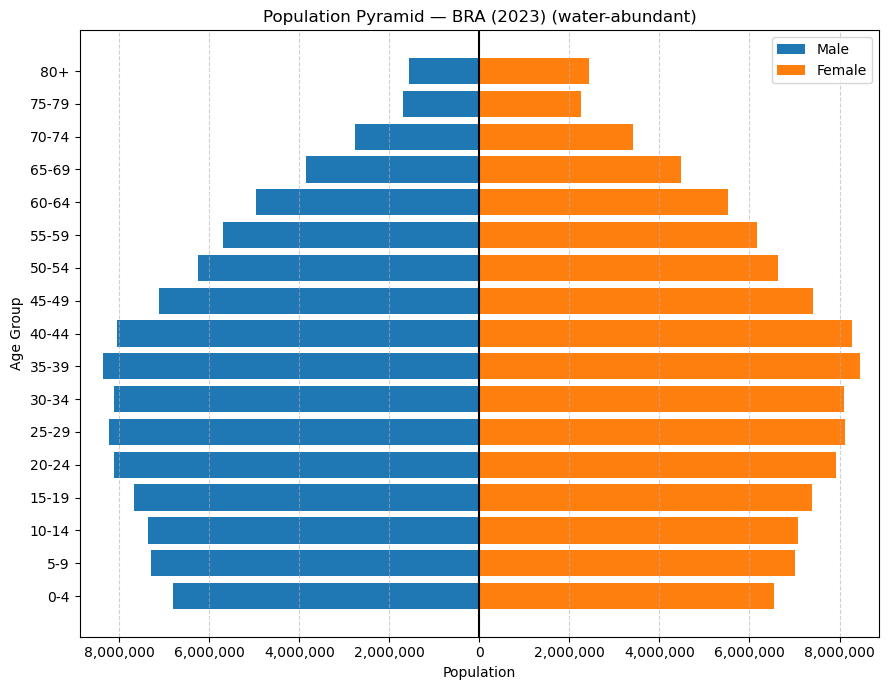

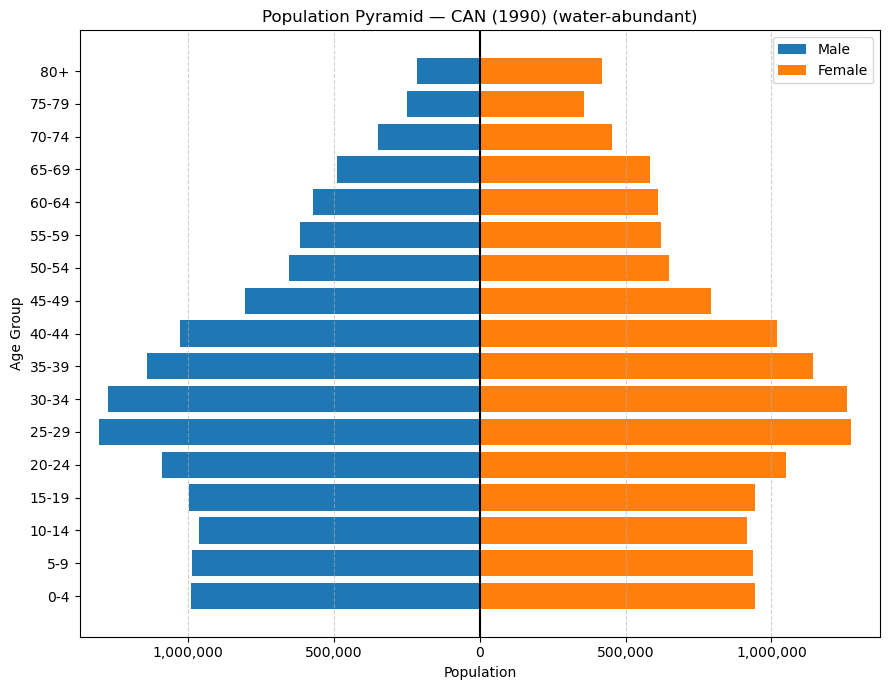

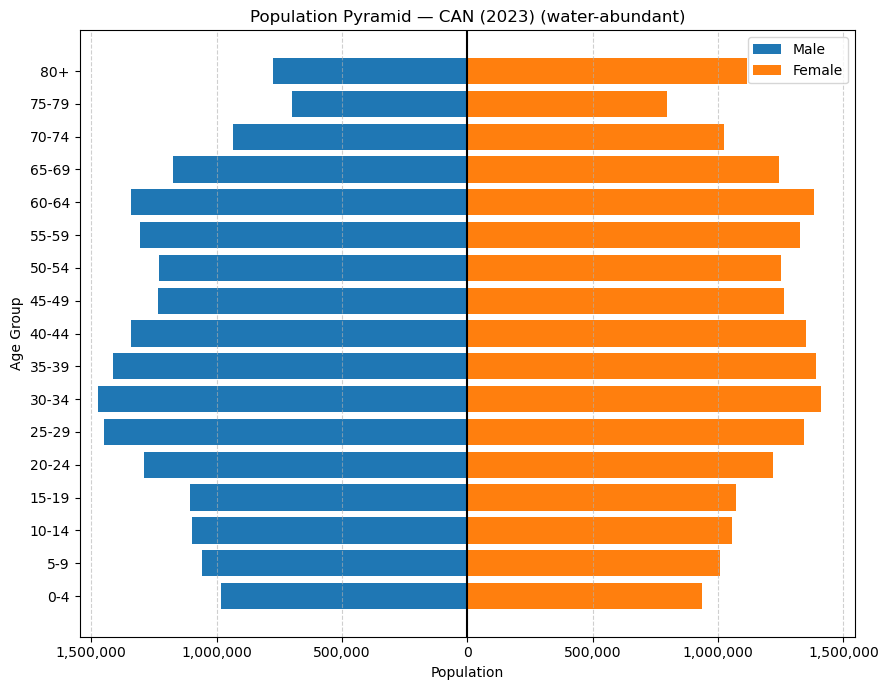

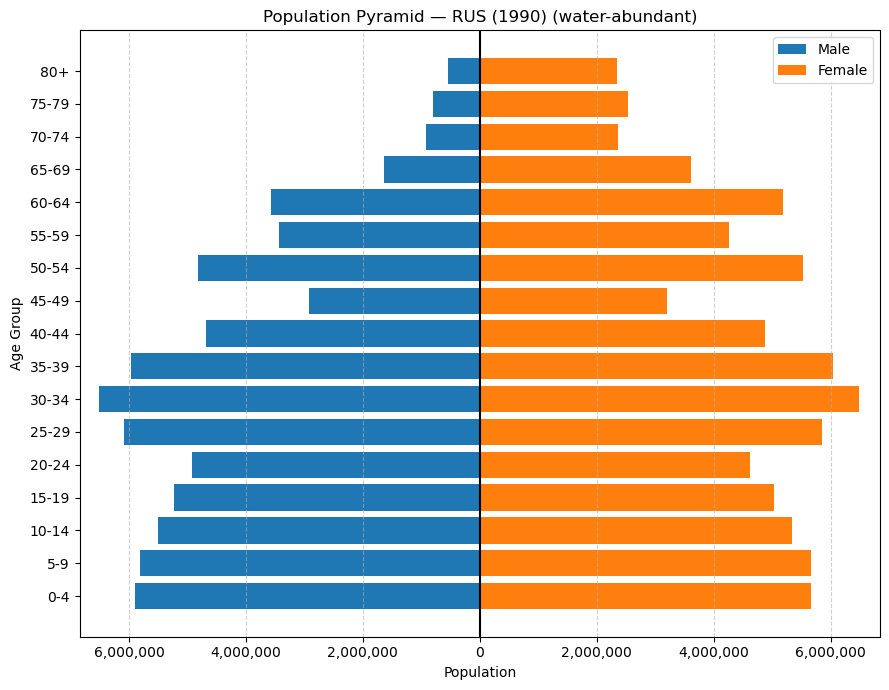

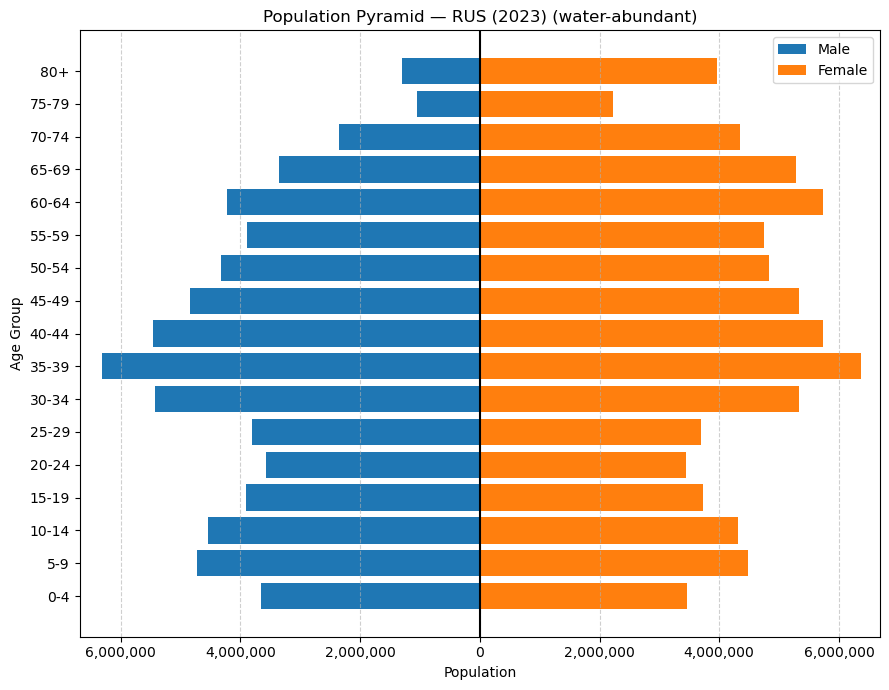

In [17]:
for iso3 in COUNTRIES:
    tag = "(water-scarce)" if iso3 in SCARCE else "(water-abundant)"
    plot_pyramid_api(iso3, 1990, title_extra=tag)
    plot_pyramid_api(iso3, 2023, title_extra=tag)


In [18]:
def animated_pyramid_api(country: str, start=1990, end=2023, title_extra=""):
    """
    Animated population pyramid using WB REST API (range pull via wb_series).
    - country: ISO3 like 'SAU'
    - start/end: years
    """
    age_order = [label for _, label in AGE_CODES]

    rows = []
    # Pull each indicator once (1990:2023) then assemble frames
    for code, age_label in AGE_CODES:
        m_ind = f"SP.POP.{code}.MA"
        f_ind = f"SP.POP.{code}.FE"

        m_series = wb_series(country, m_ind, start=start, end=end)  # {year: value}
        f_series = wb_series(country, f_ind, start=start, end=end)

        for y in range(start, end + 1):
            m = m_series.get(y, np.nan)
            f = f_series.get(y, np.nan)

            if np.isfinite(m):
                rows.append({"country": country, "year": y, "sex": "Male", "age_group": age_label, "population": -float(m)})
            if np.isfinite(f):
                rows.append({"country": country, "year": y, "sex": "Female", "age_group": age_label, "population": float(f)})

    df = pd.DataFrame(rows)
    if df.empty:
        raise ValueError(f"No animated pyramid data for {country} from {start}–{end}")

    # enforce age ordering
    df["age_group"] = pd.Categorical(df["age_group"], categories=age_order, ordered=True)

    # symmetric x-range across ALL years so axis doesn't jump
    xmin = df["population"].min()
    xmax = df["population"].max()
    xpad = 0.1 * max(abs(xmin), abs(xmax)) if np.isfinite(xmin) and np.isfinite(xmax) else 0
    xrange = [-max(abs(xmin), abs(xmax)) - xpad, max(abs(xmin), abs(xmax)) + xpad]

    fig = px.bar(
        df,
        x="population",
        y="age_group",
        color="sex",
        animation_frame="year",
        orientation="h",
        category_orders={"age_group": age_order},
        range_x=xrange,
        title=f"Animated Population Pyramid — {country} ({start}–{end}) {title_extra}".strip()
    )

    fig.update_layout(
        width=1100,
        height=600,
        margin=dict(l=80, r=80, t=80, b=60),
        xaxis_title="Population (negative = Male, positive = Female)",
        yaxis_title="Age Group",
    )

    fig.update_yaxes(autorange="reversed")

    return fig


In [19]:
display(Markdown("#### 4. [C] Animated Population Pyramids"))

for iso3 in COUNTRIES:
    tag = "(water-scarce)" if iso3 in SCARCE else "(water-abundant)"
    fig = animated_pyramid_api(iso3, start=1990, end=2023, title_extra=tag)
    fig.show()



#### 4. [C] Animated Population Pyramids

In [20]:
import time
import requests
import numpy as np

_WB_CACHE = {}  # (country, indicator, start, end) -> {year:int -> value:float}

def _wb_series_once(country: str, indicator: str, start: int, end: int, timeout=60) -> dict:
    base = f"https://api.worldbank.org/v2/country/{country}/indicator/{indicator}"
    url = f"{base}?date={start}:{end}&format=json&per_page=20000"
    r = requests.get(url, timeout=timeout, headers={"User-Agent": "Mozilla/5.0"})
    r.raise_for_status()
    data = r.json()

    out = {}
    if isinstance(data, list) and len(data) > 1 and data[1]:
        for item in data[1]:
            yr = item.get("date")
            val = item.get("value")
            try:
                y = int(yr)
            except Exception:
                continue
            out[y] = float(val) if val is not None else np.nan
    return out


def wb_series(country: str, indicator: str, start=1990, end=2023, timeout=60, retries=3) -> dict:
    """
    Robust WB range fetch:
    - retries
    - if it still fails, falls back to chunked 8-year windows (much less likely to timeout)
    """
    key = (country, indicator, start, end)
    if key in _WB_CACHE:
        return _WB_CACHE[key]

    # --- Try full range with retries
    last_err = None
    for k in range(retries):
        try:
            out = _wb_series_once(country, indicator, start, end, timeout=timeout)
            _WB_CACHE[key] = out
            return out
        except Exception as e:
            last_err = e
            time.sleep(1.5 * (k + 1))  # backoff

    # --- Fallback: chunk the range (8-year chunks)
    out = {}
    chunk = 8
    for s in range(start, end + 1, chunk):
        e = min(end, s + chunk - 1)
        ck = (country, indicator, s, e)
        if ck in _WB_CACHE:
            out.update(_WB_CACHE[ck])
            continue
        for k in range(retries):
            try:
                part = _wb_series_once(country, indicator, s, e, timeout=timeout)
                _WB_CACHE[ck] = part
                out.update(part)
                break
            except Exception:
                time.sleep(1.5 * (k + 1))
        else:
            # If a chunk totally fails, just fill with NaNs for that chunk
            for y in range(s, e + 1):
                out.setdefault(y, np.nan)

    _WB_CACHE[key] = out
    return out


In [21]:
def wb_value(country: str, indicator: str, year: int, start=1990, end=2023) -> float:
    s = wb_series(country, indicator, start=start, end=end)
    return float(s.get(int(year), np.nan))


In [22]:
# Indicators
IND_TOTAL_WITHDRAW_BCM = "ER.H2O.FWTL.K3"
IND_AG_SHARE_PCT       = "ER.H2O.FWAG.ZS"
IND_WATER_STRESS_PCT   = "ER.H2O.FWST.ZS"
IND_POP_TOTAL          = "SP.POP.TOTL"

def build_panel(countries_dict, scarce_set, start=1990, end=2023):
    rows = []

    for iso3 in countries_dict.keys():
        print(f"Fetching data for {iso3}...")

        pop_s = wb_series(iso3, IND_POP_TOTAL, start, end)
        tw_s  = wb_series(iso3, IND_TOTAL_WITHDRAW_BCM, start, end)
        ag_s  = wb_series(iso3, IND_AG_SHARE_PCT, start, end)
        ws_s  = wb_series(iso3, IND_WATER_STRESS_PCT, start, end)

        for y in range(start, end + 1):
            pop   = pop_s.get(y, np.nan)
            tw    = tw_s.get(y, np.nan)
            agpct = ag_s.get(y, np.nan)
            wspct = ws_s.get(y, np.nan)

            ag_withdraw_bcm = tw * (agpct / 100.0) if np.isfinite(tw) and np.isfinite(agpct) else np.nan
            ag_pc_m3 = (ag_withdraw_bcm * 1e9) / pop if np.isfinite(ag_withdraw_bcm) and np.isfinite(pop) and pop > 0 else np.nan

            rows.append({
                "iso3": iso3,
                "label": countries_dict[iso3],
                "group": "water-scarce" if iso3 in scarce_set else "water-abundant",
                "year": y,
                "population_total": pop,
                "water_stress_pct": wspct,
                "ag_withdraw_share_pct": agpct,
                "total_withdrawal_bcm": tw,
                "ag_withdrawal_bcm": ag_withdraw_bcm,
                "ag_water_pc_m3": ag_pc_m3
            })

    df = pd.DataFrame(rows)

    # Population index (1990 = 100)
    def pop_index(series):
        base = series.loc[df.loc[series.index, "year"] == 1990].mean()
        if np.isfinite(base):
            return (series / base) * 100
        return np.nan

    df["pop_index_1990"] = df.groupby("iso3")["population_total"].transform(pop_index)

    return df


# Build it
PANEL = build_panel(COUNTRIES, SCARCE, 1990, 2023)

print("PANEL built successfully.")
PANEL.head()


Fetching data for SAU...
Fetching data for IND...
Fetching data for BHR...
Fetching data for BRA...
Fetching data for CAN...
Fetching data for RUS...
PANEL built successfully.


,iso3,label,group,year,population_total,water_stress_pct,ag_withdraw_share_pct,total_withdrawal_bcm,ag_withdrawal_bcm,ag_water_pc_m3,pop_index_1990
0,SAU,Saudi Arabia (water-scarce),water-scarce,1990,10640691.0,NaN,NaN,NaN,NaN,NaN,100.000000
1,SAU,Saudi Arabia (water-scarce),water-scarce,1991,11160744.0,NaN,NaN,NaN,NaN,NaN,104.887399
2,SAU,Saudi Arabia (water-scarce),water-scarce,1992,11686676.0,671.666667,89.952996,16.120000,14.500423,1240.765384,109.830048
3,SAU,Saudi Arabia (water-scarce),water-scarce,1993,12215862.0,690.396875,89.620846,16.569525,14.849749,1215.612009,114.803277
4,SAU,Saudi Arabia (water-scarce),water-scarce,1994,12750040.0,708.543750,89.306678,17.005050,15.186645,1191.105700,119.823421


In [23]:
df = PANEL.dropna(subset=["ag_water_pc_m3"])
df_scarce = df[df["group"] == "water-scarce"]

fig = px.line(
    df_scarce, x="year", y="ag_water_pc_m3",
    color="iso3", markers=True,
    hover_data=["label"],
    title="Water-scarce countries: Agricultural water use per capita (m³/person), 1990–2023"
)
fig.update_layout(width=1100, height=450, yaxis_title="m³/person")
fig.show()


In [24]:
dfp = PANEL.dropna(subset=["pop_index_1990"])
dfp_scarce = dfp[dfp["group"] == "water-scarce"]

fig = px.line(
    dfp_scarce, x="year", y="pop_index_1990",
    color="iso3",
    title="Water-scarce countries: Population growth index (1990 = 100)"
)
fig.update_layout(width=1100, height=450, yaxis_title="Index")
fig.show()


In [25]:
dfR = PANEL.dropna(subset=["population_total","ag_water_pc_m3"]).sort_values(["iso3","year"])

fig = px.line(
    dfR,
    x="population_total",
    y="ag_water_pc_m3",
    color="iso3",
    line_group="iso3",
    markers=True,
    facet_col="group",
    hover_data=["year","label","water_stress_pct","ag_withdraw_share_pct"],
    title="Trajectory (1990–2023): Ag water per capita vs population"
)
fig.update_xaxes(type="log", title="Population (log scale)")
fig.update_layout(width=1100, height=520, yaxis_title="Ag water per capita (m³/person)")
fig.show()


In [26]:
dfW = PANEL.dropna(subset=["water_stress_pct"])
fig = px.line(
    dfW, x="year", y="water_stress_pct",
    color="iso3", facet_col="group",
    title="Water stress (%) over time (1990–2023)"
)
fig.update_layout(width=1100, height=450, yaxis_title="Water stress (%)")
fig.show()


In [27]:
dfS = PANEL.dropna(subset=["ag_withdraw_share_pct"])
fig = px.line(
    dfS, x="year", y="ag_withdraw_share_pct",
    color="iso3", facet_col="group",
    title="Agricultural share of withdrawals (%) over time (1990–2023)"
)
fig.update_layout(width=1100, height=450, yaxis_title="Ag share (%)")
fig.show()


In [28]:
import numpy as np

def slope_vs_population(df):
    results = []
    for iso3 in df["iso3"].unique():
        sub = df[df["iso3"] == iso3].dropna(subset=["population_total","ag_water_pc_m3"])
        if len(sub) < 5:
            continue
        x = np.log(sub["population_total"].values)
        y = sub["ag_water_pc_m3"].values
        slope = np.polyfit(x, y, 1)[0]
        results.append({"iso3": iso3, "group": sub["group"].iloc[0], "slope": slope})
    return pd.DataFrame(results)

slopes = slope_vs_population(PANEL)
display(slopes)


,iso3,group,slope
0,SAU,water-scarce,-673.614820
1,IND,water-scarce,-271.159664
2,BHR,water-scarce,-195.193826
3,BRA,water-abundant,25.687942
4,CAN,water-abundant,-141.769349
5,RUS,water-abundant,222.568003


In [29]:
# ==========================================
# Figures: Agricultural water use (1990–2023)
# Uses your existing wb_series()/PANEL workflow
# Outputs only ag-water-related plots (no pyramids)
# ==========================================

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

# --- assumes these already exist in your notebook ---
# COUNTRIES (dict iso3->label), SCARCE (set), wb_series (robust), PANEL optional
# If PANEL not built yet, this cell will build it.

# World Bank indicators
IND_TOTAL_WITHDRAW_BCM = "ER.H2O.FWTL.K3"  # total freshwater withdrawal (billion m^3)
IND_AG_SHARE_PCT       = "ER.H2O.FWAG.ZS"  # agricultural share of withdrawals (%)
IND_WATER_STRESS_PCT   = "ER.H2O.FWST.ZS"  # water stress (% of available)
IND_POP_TOTAL          = "SP.POP.TOTL"     # population

def build_ag_panel(countries_dict, scarce_set, start=1990, end=2023):
    rows = []
    for iso3 in countries_dict.keys():
        pop_s = wb_series(iso3, IND_POP_TOTAL, start, end)
        tw_s  = wb_series(iso3, IND_TOTAL_WITHDRAW_BCM, start, end)
        ag_s  = wb_series(iso3, IND_AG_SHARE_PCT, start, end)
        ws_s  = wb_series(iso3, IND_WATER_STRESS_PCT, start, end)

        for y in range(start, end + 1):
            pop   = pop_s.get(y, np.nan)
            tw    = tw_s.get(y, np.nan)
            agpct = ag_s.get(y, np.nan)
            wspct = ws_s.get(y, np.nan)

            ag_withdraw_bcm = tw * (agpct / 100.0) if np.isfinite(tw) and np.isfinite(agpct) else np.nan
            ag_pc_m3 = (ag_withdraw_bcm * 1e9) / pop if np.isfinite(ag_withdraw_bcm) and np.isfinite(pop) and pop > 0 else np.nan

            rows.append({
                "iso3": iso3,
                "label": countries_dict[iso3],
                "group": "water-scarce" if iso3 in scarce_set else "water-abundant",
                "year": y,
                "population_total": pop,
                "water_stress_pct": wspct,
                "ag_withdraw_share_pct": agpct,
                "total_withdrawal_bcm": tw,
                "ag_withdrawal_bcm": ag_withdraw_bcm,
                "ag_water_pc_m3": ag_pc_m3,
            })

    df = pd.DataFrame(rows)

    # Population index (1990=100) for comparability in relationship plots
    def _pop_index(g):
        base = g.loc[g["year"] == 1990, "population_total"].mean()
        g = g.copy()
        g["pop_index_1990"] = (g["population_total"] / base) * 100 if np.isfinite(base) else np.nan
        return g
    df = df.groupby("iso3", group_keys=False).apply(_pop_index)
    return df

# Build panel (or reuse if you already have PANEL)
try:
    AG = PANEL.copy()
except NameError:
    AG = build_ag_panel(COUNTRIES, SCARCE, 1990, 2023)

# Keep only rows where at least one key ag metric is present
# (don’t drop too aggressively; each plot drops what it needs)
AG["pop_millions"] = AG["population_total"] / 1e6

# ==========================
# FIGURE 1: Ag water per capita over time (facet by group)
# ==========================
df1 = AG.dropna(subset=["ag_water_pc_m3"])
fig1 = px.line(
    df1, x="year", y="ag_water_pc_m3",
    color="iso3", facet_col="group",
    markers=True, hover_data=["label"],
    title="Agricultural water use per capita (m³/person) over time (1990–2023)"
)
fig1.update_layout(width=1100, height=520, yaxis_title="m³/person")
fig1.show()

# ==========================
# FIGURE 2: Total agricultural withdrawals over time (billion m³)
# (helps separate “per-capita decline” from “total water changed”)
# ==========================
df2 = AG.dropna(subset=["ag_withdrawal_bcm"])
fig2 = px.line(
    df2, x="year", y="ag_withdrawal_bcm",
    color="iso3", facet_col="group",
    markers=False, hover_data=["label"],
    title="Total agricultural withdrawals (billion m³) over time (1990–2023)"
)
fig2.update_layout(width=1100, height=520, yaxis_title="billion m³")
fig2.show()

# ==========================
# FIGURE 3: Agricultural share of withdrawals over time (%)
# (one of the drivers of ag withdrawals)
# ==========================
df3 = AG.dropna(subset=["ag_withdraw_share_pct"])
fig3 = px.line(
    df3, x="year", y="ag_withdraw_share_pct",
    color="iso3", facet_col="group",
    markers=False, hover_data=["label"],
    title="Agricultural share of freshwater withdrawals (%) over time (1990–2023)"
)
fig3.update_layout(width=1100, height=520, yaxis_title="%")
fig3.show()

# ==========================
# FIGURE 4: Water stress over time (%)
# (context for water-scarce vs abundant; often has gaps)
# ==========================
df4 = AG.dropna(subset=["water_stress_pct"])
fig4 = px.line(
    df4, x="year", y="water_stress_pct",
    color="iso3", facet_col="group",
    markers=False, hover_data=["label"],
    title="Water stress (% of available freshwater withdrawn) over time (1990–2023)"
)
fig4.update_layout(width=1100, height=520, yaxis_title="%")
fig4.show()

# ==========================
# FIGURE 5 (KEY): Trajectory — ag water per capita vs population (log x)
# Directly answers: “as populations grow, how does ag water per capita change?”
# ==========================
df5 = AG.dropna(subset=["population_total","ag_water_pc_m3"]).sort_values(["iso3","year"])
fig5 = px.line(
    df5,
    x="population_total",
    y="ag_water_pc_m3",
    color="iso3",
    line_group="iso3",
    markers=True,
    facet_col="group",
    hover_data=["year","label","water_stress_pct","ag_withdraw_share_pct"],
    title="Trajectory (1990–2023): Ag water per capita vs population"
)
fig5.update_xaxes(type="log", title="Population (log scale)")
fig5.update_layout(width=1100, height=560, yaxis_title="Ag water per capita (m³/person)")
fig5.show()

# ==========================
# FIGURE 6: Group medians over time (scarce vs abundant)
# (simple “headline trend” figure)
# ==========================
df6 = AG.dropna(subset=["ag_water_pc_m3"]).copy()
grp = df6.groupby(["group","year"])["ag_water_pc_m3"].median().reset_index(name="median_ag_pc")

fig6 = px.line(
    grp, x="year", y="median_ag_pc",
    color="group",
    markers=True,
    title="Median ag water per capita by group (water-scarce vs water-abundant)"
)
fig6.update_layout(width=900, height=450, yaxis_title="m³/person")
fig6.show()

# ==========================
# Optional: quick data coverage table (helps explain gaps)
# ==========================
coverage = AG.groupby(["iso3","group"]).agg(
    years_ag_pc=("ag_water_pc_m3", lambda s: int(np.isfinite(s).sum())),
    years_ag_withdraw=("ag_withdrawal_bcm", lambda s: int(np.isfinite(s).sum())),
    years_ag_share=("ag_withdraw_share_pct", lambda s: int(np.isfinite(s).sum())),
    years_water_stress=("water_stress_pct", lambda s: int(np.isfinite(s).sum())),
).reset_index()
display(coverage)


,iso3,group,years_ag_pc,years_ag_withdraw,years_ag_share,years_water_stress
0,BHR,water-scarce,33,33,33,33
1,BRA,water-abundant,27,27,27,33
2,CAN,water-abundant,32,32,32,33
3,IND,water-scarce,33,33,33,33
4,RUS,water-abundant,29,29,29,31
5,SAU,water-scarce,31,31,31,31


In [30]:
# =========================================================
# Overlay plots: Ag-water metrics + population growth (1990–2023)
# (cleaner than dual-axis clutter: normalize to 1990=100 and overlay)
# =========================================================

import numpy as np
import pandas as pd
import plotly.express as px

# Assumes AG exists from prior cell (or PANEL/AG panel built)
# Required columns in AG:
# year, iso3, group, label, population_total, ag_water_pc_m3, ag_withdrawal_bcm,
# ag_withdraw_share_pct, water_stress_pct

def add_index_cols(df, cols, base_year=1990):
    """
    For each iso3 and each column in cols, create <col>_idx where base_year = 100.
    If base_year missing, uses first available year for that series as the base.
    """
    out = df.copy()

    def _index_one_country(g):
        g = g.sort_values("year").copy()
        for c in cols:
            s = g[c]
            base = s[g["year"] == base_year].mean()
            if not np.isfinite(base):
                # fallback: first non-NaN
                base = s.dropna().iloc[0] if s.dropna().shape[0] else np.nan
            g[c + "_idx"] = (s / base) * 100 if np.isfinite(base) and base != 0 else np.nan
        return g

    out = out.groupby("iso3", group_keys=False).apply(_index_one_country)
    return out

# Choose which ag metrics you want to overlay with population
AG2 = add_index_cols(
    AG,
    cols=["population_total", "ag_water_pc_m3", "ag_withdrawal_bcm", "water_stress_pct", "ag_withdraw_share_pct"],
    base_year=1990
)

def overlay_two_indices(df, metric_col_idx, title, facet_by_group=True):
    """
    Overlay population index (1990=100) with another indexed metric (1990=100),
    with line dashing to distinguish them.
    """
    # Long format: one row per iso3-year-metric
    keep = df.dropna(subset=["population_total_idx", metric_col_idx]).copy()

    pop_long = keep[["iso3","label","group","year","population_total_idx"]].rename(
        columns={"population_total_idx":"index_value"}
    )
    pop_long["series"] = "Population (index)"

    met_long = keep[["iso3","label","group","year",metric_col_idx]].rename(
        columns={metric_col_idx:"index_value"}
    )
    met_long["series"] = metric_col_idx.replace("_idx","").replace("_"," ").title() + " (index)"

    long = pd.concat([pop_long, met_long], ignore_index=True)

    fig = px.line(
        long,
        x="year",
        y="index_value",
        color="iso3",
        line_dash="series",
        hover_data=["label","series"],
        facet_col="group" if facet_by_group else None,
        title=title
    )
    fig.update_layout(
        width=1100,
        height=520,
        yaxis_title="Index (base year = 100)",
        legend_title_text="Country / Series",
        margin=dict(l=70, r=40, t=70, b=60),
    )
    fig.show()

# -------------------------
# Overlay 1: Ag water per capita vs population (both indexed)
# -------------------------
overlay_two_indices(
    AG2,
    metric_col_idx="ag_water_pc_m3_idx",
    title="Overlay: Population growth vs Agricultural water use per capita (indexed to 1990=100)",
    facet_by_group=True
)

# -------------------------
# Overlay 2: Total agricultural withdrawals vs population (both indexed)
# -------------------------
overlay_two_indices(
    AG2,
    metric_col_idx="ag_withdrawal_bcm_idx",
    title="Overlay: Population growth vs Total agricultural withdrawals (indexed to 1990=100)",
    facet_by_group=True
)

# -------------------------
# Overlay 3: Water stress vs population (both indexed)
# (note: water stress often has missing years; still useful)
# -------------------------
overlay_two_indices(
    AG2,
    metric_col_idx="water_stress_pct_idx",
    title="Overlay: Population growth vs Water stress (indexed to 1990=100)",
    facet_by_group=True
)

# -------------------------
# Overlay 4: Ag share of withdrawals vs population (both indexed)
# -------------------------
overlay_two_indices(
    AG2,
    metric_col_idx="ag_withdraw_share_pct_idx",
    title="Overlay: Population growth vs Agricultural share of withdrawals (indexed to 1990=100)",
    facet_by_group=True
)


/tmp/ipykernel_7108/3209629869.py:33: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [31]:
# =========================================================
# Absolute-units overlay WITHOUT dual-axis clutter:
# 2-row subplot per country (same x-axis)
#   Row 1: Ag metric (absolute units)
#   Row 2: Population (millions)
# Faceted by country (one figure per country) so units stay honest.
# =========================================================

import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Assumes AG exists with columns:
# year, iso3, label, group, population_total, ag_water_pc_m3, ag_withdrawal_bcm,
# ag_withdraw_share_pct, water_stress_pct

def plot_country_overlay_absolute(df, iso3, start=1990, end=2023, metric="ag_water_pc_m3"):
    """
    metric options: "ag_water_pc_m3", "ag_withdrawal_bcm", "ag_withdraw_share_pct", "water_stress_pct"
    Produces a 2-row subplot:
      - Top: chosen metric in absolute units
      - Bottom: population in millions
    """
    sub = df[(df["iso3"] == iso3) & (df["year"] >= start) & (df["year"] <= end)].copy().sort_values("year")
    if sub.empty:
        print(f"No data for {iso3}")
        return

    # Prepare population (millions)
    sub["pop_millions"] = sub["population_total"] / 1e6

    metric_labels = {
        "ag_water_pc_m3": ("Ag water per capita", "m³/person"),
        "ag_withdrawal_bcm": ("Total ag withdrawals", "billion m³"),
        "ag_withdraw_share_pct": ("Ag share of withdrawals", "%"),
        "water_stress_pct": ("Water stress", "%"),
    }
    title_name, yunit = metric_labels.get(metric, (metric, ""))

    fig = make_subplots(
        rows=2, cols=1,
        shared_xaxes=True,
        vertical_spacing=0.08,
        subplot_titles=(f"{title_name} ({yunit})", "Population (millions)")
    )

    # Row 1: metric
    fig.add_trace(
        go.Scatter(
            x=sub["year"],
            y=sub[metric],
            mode="lines+markers",
            name=f"{iso3} {metric}",
            hovertemplate="Year=%{x}<br>Value=%{y}<extra></extra>"
        ),
        row=1, col=1
    )

    # Row 2: population
    fig.add_trace(
        go.Scatter(
            x=sub["year"],
            y=sub["pop_millions"],
            mode="lines+markers",
            name=f"{iso3} population",
            hovertemplate="Year=%{x}<br>Pop=%{y:.1f}M<extra></extra>"
        ),
        row=2, col=1
    )

    fig.update_layout(
        title=f"{iso3} — {df[df['iso3']==iso3]['label'].iloc[0]} | {start}–{end}",
        width=950,
        height=650,
        margin=dict(l=70, r=40, t=90, b=60),
        showlegend=False
    )
    fig.update_xaxes(title_text="Year", row=2, col=1)

    # Nice y-axis titles
    fig.update_yaxes(title_text=yunit if yunit else "Value", row=1, col=1)
    fig.update_yaxes(title_text="Millions", row=2, col=1)

    fig.show()


# ==========================
# Produce the key overlays per country
# ==========================

# 1) Ag water per capita vs population (absolute)
for iso3 in COUNTRIES.keys():
    plot_country_overlay_absolute(AG, iso3, metric="ag_water_pc_m3")

# 2) Total ag withdrawals vs population (absolute) — optional but very informative
for iso3 in COUNTRIES.keys():
    plot_country_overlay_absolute(AG, iso3, metric="ag_withdrawal_bcm")

# 3) Water stress vs population (absolute) — optional, may have gaps
for iso3 in COUNTRIES.keys():
    plot_country_overlay_absolute(AG, iso3, metric="water_stress_pct")

# 4) Ag share vs population (absolute) — optional
for iso3 in COUNTRIES.keys():
    plot_country_overlay_absolute(AG, iso3, metric="ag_withdraw_share_pct")
